In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from functools import partial
from matplotlib import pyplot as plt 
import numpy as np
import seaborn as sns

## Wczytanie danych

In [4]:
df = pd.read_csv("../../clustering.csv",header=None,names=['x','y'])

## Podstawowe informacje o zbiorze

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       400 non-null    float64
 1   y       400 non-null    float64
dtypes: float64(2)
memory usage: 6.4 KB


In [5]:
df.describe()

,x,y
count,400.000000,400.000000
mean,-0.580656,-8.010264
std,48.821210,62.096845
min,-107.433649,-128.983720
25%,-34.551495,-70.730416
50%,5.691010,-3.447565
75%,31.456507,45.822610
max,109.733409,99.935839


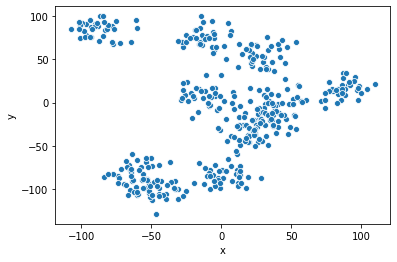

In [6]:
sns.scatterplot(df['x'],df['y'])

Widać iż zbiór jest wyraźnie podzielony na kilka klas, ale cięzko jednoznacznie stwierdzić na ile konkretnie.

## Standaryzacja zmiennych

In [7]:
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns]) 

In [8]:
df.describe()

,x,y
count,4.000000e+02,4.000000e+02
mean,1.110223e-17,-2.220446e-17
std,1.001252e+00,1.001252e+00
min,-2.191400e+00,-1.950581e+00
25%,-6.966927e-01,-1.011303e+00
50%,1.286228e-01,7.356917e-02
75%,6.570358e-01,8.680037e-01
max,2.262382e+00,1.740528e+00


# Kmeans

Jak pierwszą metodę zdecydowałem się użyć metodę Kmeans. Aby dobrać odpowiednie k, użyję metody łokcia.

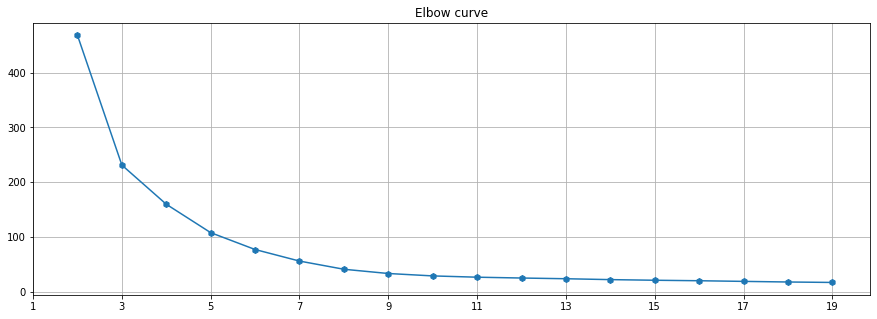

In [9]:

def plot_score_kmeans(df,metod,title):
    scors = []
    for k in range(2, 20):
        met = metod(k)
        met.fit(df)
        scors.append(met.inertia_)
    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(2, 20), scors,marker='h')
    plt.xticks(np.arange(1,21, 2))
    plt.grid(True)
    plt.title(title)
model = partial(KMeans)
plot_score_kmeans(df,model,title = 'Elbow curve')

Cięzko jednoznacznie na podstawie tego wykresu dobrać odpowiednie k. Ja zdecyduję się na sprawdzenie k równego 7,8 oraz 9.

In [10]:
def plot(df,model):
    data = df.copy()
    label = model.fit_predict(data)
    data['label'] = label
    sns.lmplot(data = data, x='x', y='y', hue='label', fit_reg=False)


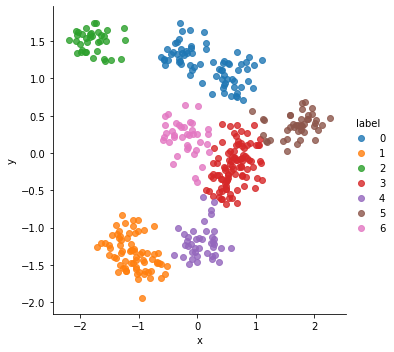

In [11]:
model = KMeans(n_clusters=7)
plot(df,model)

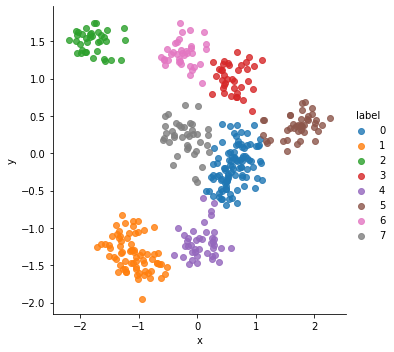

In [12]:
model = KMeans(n_clusters=8)
plot(df,model)

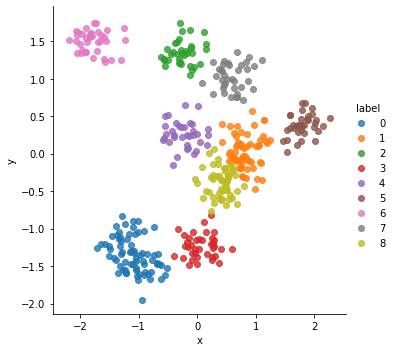

In [13]:
model = KMeans(n_clusters=9)
plot(df,model)

Oba wydają się dość racjonalne, aczkolwiek k=8 dzieli dane trochę porównywalne jak k=9, a także zdecydowanie lepiej niż 7 w przypadku którego klaster na górze wydaje się być sztuczne złączony w jeden.

# Gausian mixture

Drugim algorytem którego użyję będzie Gaussian Mixture, a odpowiednią ilość klastrów dla niego znajdę za pomocą metody silhouette.

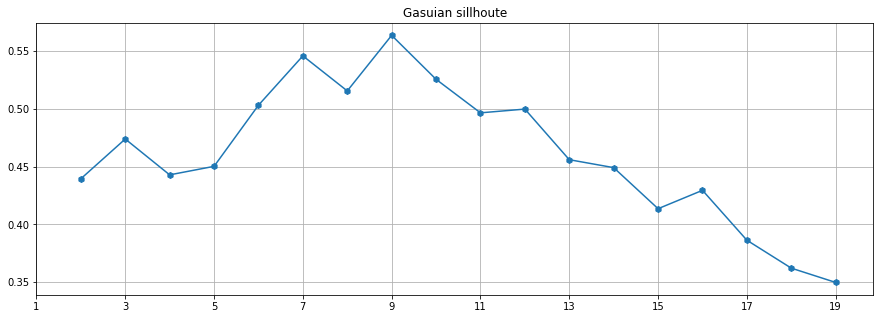

In [14]:

def plot_score_gauss(df,metod,title):
    scors = []
    for k in range(2, 20):
        met = metod(k)
        label = met.fit_predict(df)
        scors.append(silhouette_score(df,label))
    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(2, 20), scors,marker='h')
    plt.xticks(np.arange(1,21, 2))
    plt.grid(True)
    plt.title(title)

    
model = partial(GaussianMixture)
plot_score_gauss(df,model,title = 'Gasuian sillhoute')

Tym razem wyraźnie widać, że najelepszy wynik mamy dla k=9.

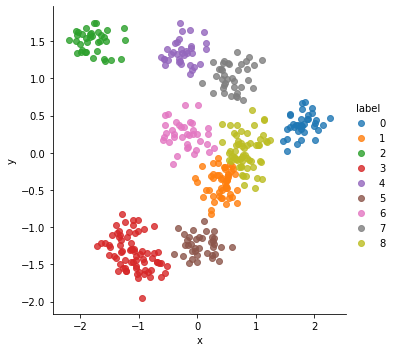

In [20]:
db = GaussianMixture(n_components=9)
plot(df,db)

Wynik który uzyskaliśmy dośc mocno różni, się zwłaszcza dl klastra pośrodku, oraz tego na górze. Z racji na brak etykiet cięzko mi stwierdzić, który algorytm lepiej sobie poradził, ale moje odczucie jest takie że Kmeans lepiej wypełnił swoje zadanie.

## Porównanie

Podziały dokonane przez algorytmy postaram się porównać miarą znaną jako Variance Ratio Criterion. Im wyższy wynik tej miary, tym lepiej zdefiniowane są klastry.

In [27]:
kmeans_model8 = KMeans(n_clusters=8).fit(df)
kmeans_model9 = KMeans(n_clusters=9).fit(df)
labels8 = kmeans_model8.labels_
labels9 = kmeans_model9.labels_
labels8g= GaussianMixture(8).fit_predict(df)
labels9g= GaussianMixture(9).fit_predict(df)
print(f'Wynik uzyskany przez Kmeans dla k=8 to :{calinski_harabasz_score(df,labels8)}')
print(f'Wynik uzyskany przez Kmeans dla k=9 to :{calinski_harabasz_score(df,labels9)}')
print(f'Wynik uzyskany przez Gausian Mixture dla k=8 to : {calinski_harabasz_score(df,labels8g)}')
print(f'Wynik uzyskany przez Gausian Mixture dla k=9 to : {calinski_harabasz_score(df,labels9g)}')

Wynik uzyskany przez Kmeans dla k=8 to :1042.1172416116717
Wynik uzyskany przez Kmeans dla k=9 to :1134.8037496576808
Wynik uzyskany przez Gausian Mixture dla k=8 to : 971.6753290736061
Wynik uzyskany przez Gausian Mixture dla k=9 to : 946.0876691413705


Obie metody prezentują się dobrze, aczkolwiek Kmeans z k=9 uzyskałl lepszy wynik wedle tej miary i to on może zostać ogłoszony zwycięzcą tego porównania.